In [1]:
# Imports
%matplotlib notebook
import cvxpy as cp
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver
from local_solver import projection_error, StereoLocalizationProblem
from sdp_relaxation import (
    build_general_SDP_problem,
    block_diagonal,
    build_cost_matrix,
    build_rotation_constraint_matrices,
    build_measurement_constraint_matrices,
    build_parallel_constraint_matrices,
    extract_solution_from_X,
)
import mosek
import iterative_sdp
import scipy as sp

In [42]:
# make camera
cam = sim.Camera(
    f_u = 160, # focal length in horizonal pixels
    f_v = 160, # focal length in vertical pixels
    c_u = 320, # pinhole projection in horizonal pixels
    c_v = 240, # pinhold projection in vertical pixels
    b = 0.25, # baseline (meters)
    R = 0.0 * np.eye(4), # covarience matrix for image-space noise
    fov = np.array([[-1,1], [-1, 1], [2, 5]])
)

world = sim.World(
    cam = cam,
    p_wc_extent = np.array([[3], [3], [0]]),
    num_landmarks = 5,
)
use_redundant=False

<IPython.core.display.Javascript object>


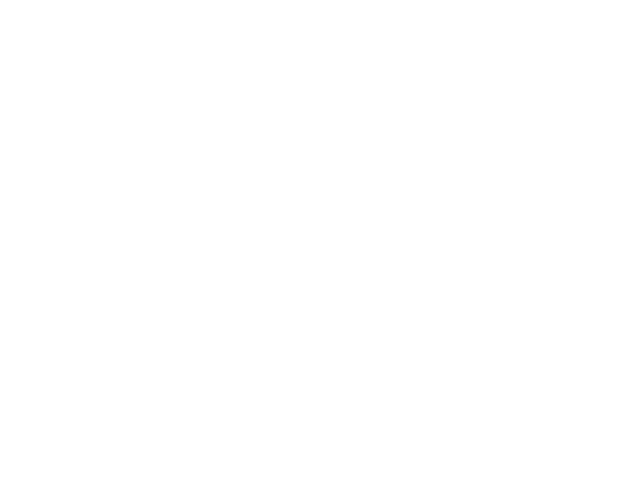

<IPython.core.display.Javascript object>


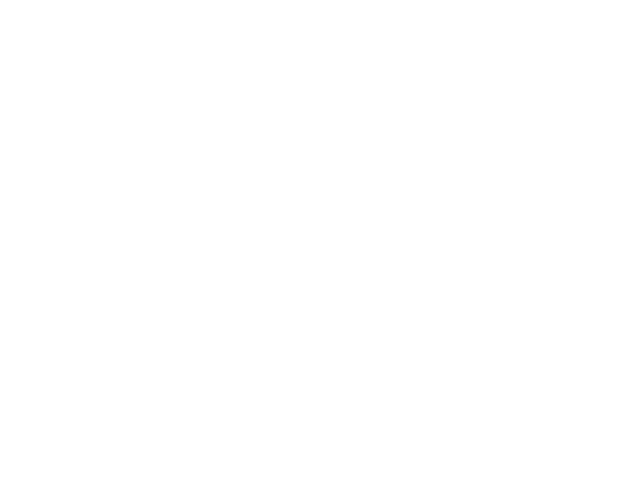

In [56]:
# make random camera pose
"""a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 5
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, cam.fov)"""

world.clear_sim_instance()
world.make_random_sim_instance()
fig, ax, colors = world.render()

# Generative camera model 
y = cam.take_picture(world.T_wc, world.p_w)
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

In [57]:
if False: # tims problem
        # groundtruth pose
        T_cw = np.array([[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 1.2], [0, 0, 0, 1]])  

        # groundtruth landmarks
        J = 5;
        p_w = np.zeros((J,4,1))
        p_w[0,:,:] = np.matrix('1; 1; 2; 1')
        p_w[1,:,:] = np.matrix('1; -1; 2; 1')
        p_w[2,:,:] = np.matrix('-1; 1; 2; 1')
        p_w[3,:,:] = np.matrix('-1; -1; 2; 1')
        p_w[4,:,:] = np.matrix('0; 0; 3; 1')
        
        world.p_w = p_w
        world.T_wc = np.linalg.inv(T_cw)

        a = np.array([[0], [0], [1], [0]])

        # constant camera matrix
        b = 0.2
        f_u = 100
        f_v = 100
        c_u = 50
        c_v = 50
        
        cam = sim.Camera(
            f_u = f_u, # focal length in horizonal pixels
            f_v = f_v, # focal length in vertical pixels
            c_u = c_u, # pinhole projection in horizonal pixels
            c_v = c_v, # pinhold projection in vertical pixels
            b = b, # baseline (meters)
            R = 0 * np.eye(4), # covarience matrix for image-space noise
            fov = np.array([[-1,1], [-1, 1], [2, 5]])
        )

        
        # generate measurements with small amount of noise
        world.cam = cam
        y = cam.take_picture(world.T_wc, world.p_w)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [58]:
W =  np.eye(4)
r0 = np.zeros((3, 1))
gamma_r = 0
T_op = np.eye(4)

problem = StereoLocalizationProblem(world.T_wc, world.p_w, cam.M(), W, y, r_0 = r0, gamma_r = gamma_r)
problem.T_init = T_op
solution = local_solver.stereo_localization_gauss_newton(problem, log = True)
T_op = solution.T_cw
local_minima = solution.cost
print("Estimate:\n", T_op)
print("Ground Truth:\n", np.linalg.inv(world.T_wc))

Loss: [[2729.40908854]]
Loss: [[65.53912682]]
Loss: [[0.0121716]]
Loss: [[1.86061995e-09]]
Loss: [[2.77880987e-24]]
Loss: [[5.00508894e-24]]
Estimate:
 [[ 0.87182954 -0.48694158  0.05292593 -1.30737954]
 [ 0.48726215  0.87322318  0.00754153 -0.9671073 ]
 [-0.04988844  0.01921387  0.99856996  0.07659729]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.87182954 -0.48694158  0.05292593 -1.30737954]
 [ 0.48726215  0.87322318  0.00754153 -0.9671073 ]
 [-0.04988844  0.01921387  0.99856996  0.07659729]
 [ 0.          0.          0.          1.        ]]


In [59]:
eps = 1e-10 # try 1e-10
mosek_params = {
    "MSK_DPAR_INTPNT_CO_TOL_DFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_PFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": eps,
}
X = iterative_sdp.iterative_sdp_solution(
    problem,
    np.eye(4),
    max_iters = 100,
    min_update_norm = 1e-6,
    mosek_params = mosek_params
)

T_sdp = extract_solution_from_X(X)
print("SDP Solution:\n", T_sdp)
cost = projection_error(y, T_sdp, cam.M(), world.p_w, W)
print("SDP Solution Cost:", cost)
print("Local Solution Cost:", local_minima[0][0])

Small update, breaking on iteration 4
SDP Solution:
 [[ 0.87182953 -0.48694158  0.05292604 -1.30737988]
 [ 0.48726216  0.87322318  0.00754142 -0.96710692]
 [-0.04988847  0.01921402  0.99856996  0.07659704]
 [ 0.          0.          0.          1.        ]]
SDP Solution Cost: 1.3067993761657292e-10
Local Solution Cost: 5.0050889407993745e-24


/var/folders/_y/_blng15n30s1q2gzf3p3sw2w0000gn/T/ipykernel_10131/1392389762.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))


<IPython.core.display.Javascript object>


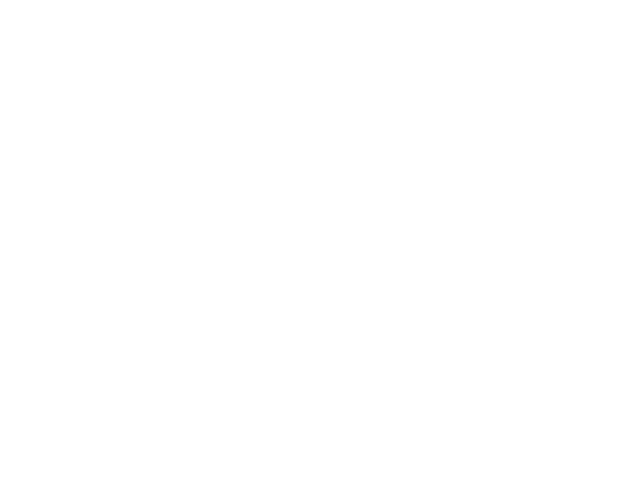

In [60]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))
plt.ylabel("$\log_{10}(\lambda)$")
plt.savefig("eigs.png")

In [61]:
e_3 = np.zeros((4, 1))
e_3[2] = 1
v = (T_op @ world.p_w) / (e_3.T @ (T_op @ world.p_w))
assert np.isclose((np.eye(4,4) - v @ e_3.T) @ (T_op @ world.p_w), 0).all()

<IPython.core.display.Javascript object>


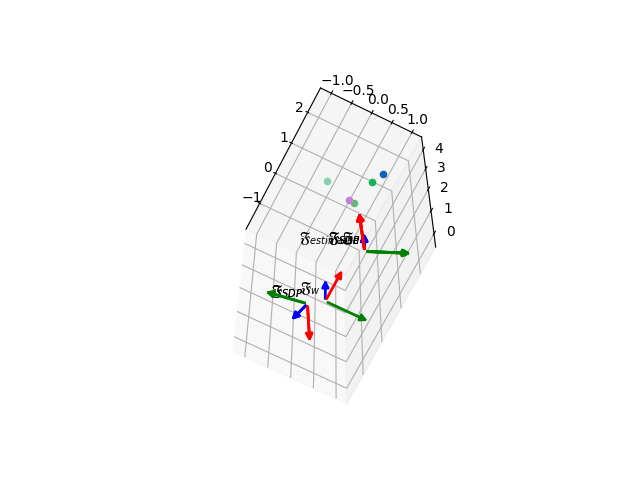

In [62]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation Math

See `math.tex`


## From Stereo Localization to QCQP, and QCQP to SDP

We will define:
$$\mathbf{x} = \begin{bmatrix} \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3 \\ \mathbf{r} \\ \mathbf{u}_1 \\ \dots \\ \mathbf{u}_n \\ \omega\end{bmatrix} \in \mathbb{R}^{13 + 3n}$$

In [63]:
# build x_local from local solution to test matricies
T_op = np.eye(4)
Ws = np.zeros((world.num_landmarks, 4, 4))
for i in range(world.num_landmarks):
    Ws[i] = W
x_1 = T_op[:3, :].T.reshape((12, 1))
x_2 = (T_op @ world.p_w / np.expand_dims((np.array([0, 0, 1, 0]) @ T_op @ world.p_w), -1))[:, [0, 1, 3], :].reshape(-1, 1)
#x_local = np.concatenate((x_1, x_2, np.array([[1]])), axis = 0)

### Cost Matrix

In [64]:
# Fow now use the same W for each measurement


# build cost matrix and compare to local solution
n = 13 + 3 * world.num_landmarks
Q = build_cost_matrix(world.num_landmarks, y, Ws, cam.M(), r0, gamma_r)
#print(x_local.T @ Q @ x_local, local_minima)

### Constraints

In [93]:
As = []
bs = []

# rotation matrix
rot_matrix_As, bs = build_rotation_constraint_matrices()
for rot_matrix_A in rot_matrix_As:
    A = np.zeros((n, n))
    A[:9, :9] = rot_matrix_A
    As.append(A)

# homogenization variable
A = np.zeros((n, n))
A[-1, -1] = 1
As.append(A)
bs.append(1)

# measurments
A_measure, b_measure = build_measurement_constraint_matrices(world.p_w)
As += A_measure
bs += b_measure

# redundant constraints
if False:
    A_par, b_par = build_parallel_constraint_matrices(world.p_w)
    As += A_par
    bs += b_par

In [90]:
"""
eps = 1e-10 # try 1e-10
mosek_params = {
    "MSK_DPAR_INTPNT_CO_TOL_DFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_PFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": eps,
}
"""

Q_new = Q / np.mean(np.abs(Q)) # improve numerics
prob, X = build_general_SDP_problem(Q_new, As, bs)
prob.solve(solver=cp.MOSEK, verbose = True)# , mosek_params = mosek_params)

# Print result.
print("The optimal value from the SDP is", prob.value)
print("The optimal value from the local solver is", local_minima)
#print("A solution X is")
X = X.value
print("SDP Solution rank:", np.linalg.matrix_rank(X))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jan 03 09:24:56 PM: Your problem has 784 variables, 23 constraints, and 0 parameters.
(CVXPY) Jan 03 09:24:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 03 09:24:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 03 09:24:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 03 09:24:56 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jan 03 09:24:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

(CVXPY) Jan 03 09:24:57 PM: Optimal value: 1.177e-08
(CVXPY) Jan 03 09:24:57 PM: Compilation took 1.846e-01 seconds
(CVXPY) Jan 03 09:24:57 PM: Solver (including time spent in interface) took 1.223e-01 seconds
The optimal value from the SDP is 1.17749422327261e-08
The optimal value from the local solver is [[5.00508894e-24]]
SDP Solution rank: 28


# Extract Solution V2



In [88]:
print("Ground Truth:\n", np.linalg.inv(world.T_wc))
T_sdp = extract_solution_from_X(X)
print("SDP Solution:\n", T_sdp)
cost = projection_error(y, T_sdp, cam.M(), world.p_w, W)
print("SDP Solution Cost:", cost)
print("Local Solution Cost:", local_minima[0][0])

Ground Truth:
 [[ 0.87182954 -0.48694158  0.05292593 -1.30737954]
 [ 0.48726215  0.87322318  0.00754153 -0.9671073 ]
 [-0.04988844  0.01921387  0.99856996  0.07659729]
 [ 0.          0.          0.          1.        ]]
SDP Solution:
 [[-0.40715294  0.23161294 -0.88350548  0.34631479]
 [-0.04791037 -0.97139765 -0.23257515 -0.01033317]
 [-0.91210256 -0.05236458  0.40660407 -0.88395702]
 [ 0.          0.          0.          1.        ]]
SDP Solution Cost: 99369179.14248334
Local Solution Cost: 5.0050889407993745e-24


<IPython.core.display.Javascript object>


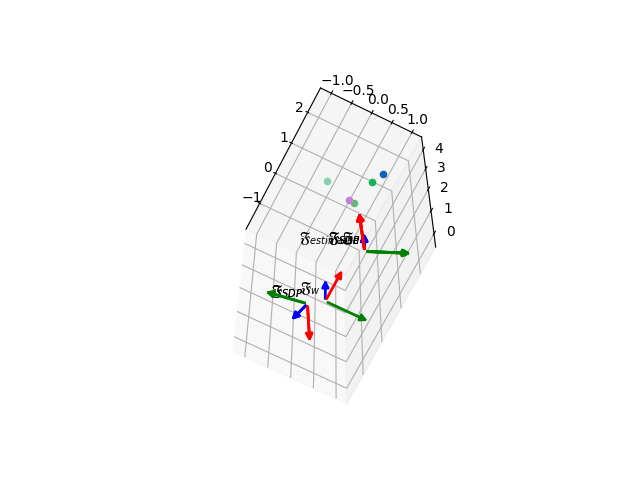

In [85]:
plotting.add_coordinate_frame(np.linalg.inv(T_sdp), ax, "$\mathfrak{F}_{SDP}$")
fig

<IPython.core.display.Javascript object>


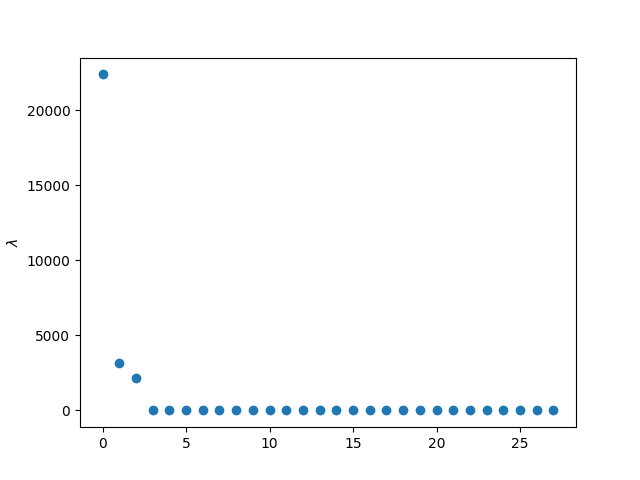

In [74]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
plt.savefig("eigs.png")

<IPython.core.display.Javascript object>


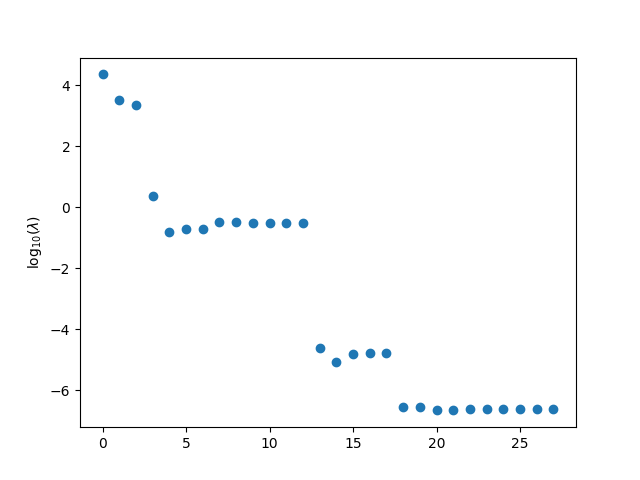

In [71]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))
plt.ylabel("$\log_{10}(\lambda)$")
plt.savefig("eigs.png")

# Certificate

In [72]:
# len(As) = 6 + J*3 + 1

In [73]:
lhs = np.concatenate([A @ x_local for A in As], axis = 1) # \in R^((12 + J*5 + 1), (12 + J*3 + 1))
rhs = Q @ x_local
lag_mult = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
lag_mult.shape
H = Q - sum([A * lag_mult[i] for i, A in enumerate(As)])
#np.all(np.linalg.eigvals(H) > 0)
eig_values, _ = np.linalg.eig(H)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
print(f"Minimum eigenvalue of H: {eig_values.min()}, Maximum eigenvalue of H: {eig_values.max()}")

NameError: name 'x_local' is not defined

In [ ]:
# plot the sparsity of the X matrix (should look dense for rank 1)
Hplt = np.zeros((H.shape[0],H.shape[1],3))
Hplt[abs(H)<1e-50] = [1,1,1]
plt.matshow(Hplt, cmap='Greys')
plt.show()